<a href="https://colab.research.google.com/github/tripatheea/transform/blob/main/without_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy import interpolate
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

In [ ]:
depth = 10

data = np.load(f'/content/drive/MyDrive/transform/depth_varied_1_to_100_injs.npz')

In [ ]:
x, y = data['x'], data['y']

In [ ]:
# x, y = x[:1000], y[:1000]

y[19990:]

array([1., 1., 0., 1., 1., 0., 1., 1., 1., 0.])

In [ ]:
x.shape, y.shape

((20000, 10, 382, 4), (20000,))

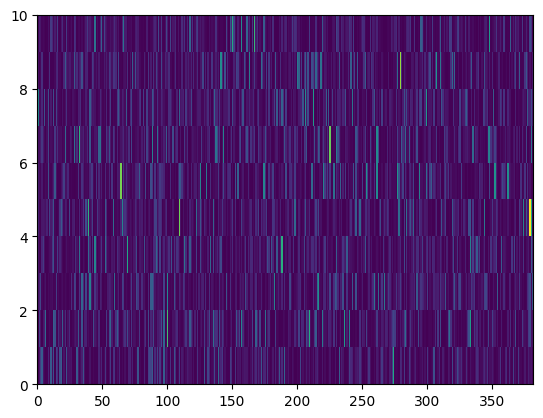

In [ ]:
idx = 19992

plt.pcolormesh(x[idx,:,:,0]**2 + x[idx,:,:,1]**2)

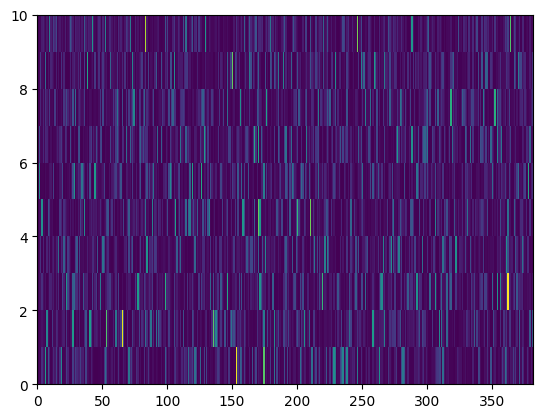

In [ ]:
plt.pcolormesh(x[idx,:,:,2]**2 + x[idx,:,:,3]**2)

In [ ]:
x.shape

(20000, 10, 382, 4)

In [ ]:
# x = np.transpose(x, (0, 2, 3, 1))

In [ ]:
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import normalize
# 
# scaled_x_s = np.array(x)

scaled_x_s = x
scaled_x_s.shape

(20000, 10, 382, 4)

In [ ]:
shuffle = False

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x, y, test_size=0.05, random_state=42, shuffle=shuffle)
x_test_s, x_val_s, y_test_s, y_val_s = train_test_split(x_test_s, y_test_s, test_size=0.5, random_state=26, shuffle=shuffle)

x_train_s.shape, x_val_s.shape, x_test_s.shape

((19000, 10, 382, 4), (500, 10, 382, 4), (500, 10, 382, 4))

In [ ]:
y_train_s[:5], x_train_s[0,:,:,0].T.shape

(array([0., 0., 0., 1., 0.]), (382, 10))

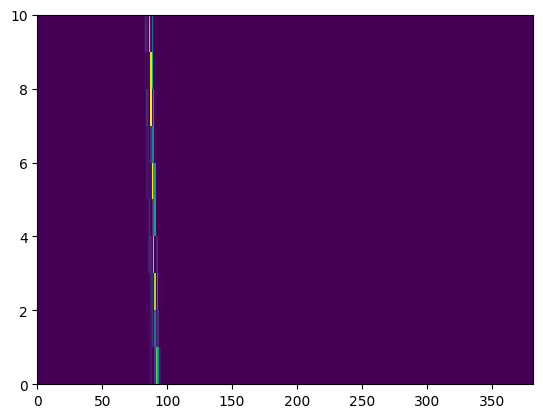

In [ ]:
idx = 3

plt.pcolormesh(x_train_s[idx,:,:,0]**2 + x_train_s[idx,:,:,1]**2)

In [ ]:
y_val_s[:5], x_train_s[0,:,:,0].T.shape

(array([0., 0., 1., 1., 1.]), (382, 10))

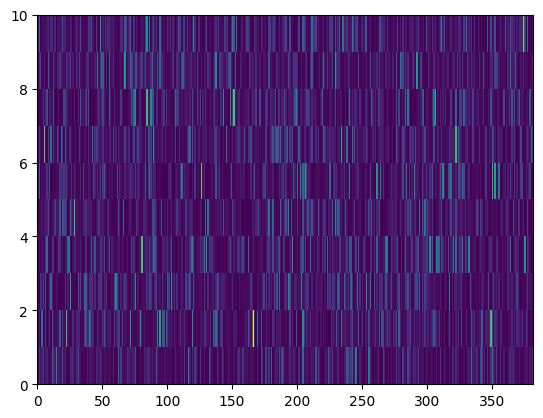

In [31]:
idx = 3

plt.pcolormesh(x_val_s[idx,:,:,0]**2 + x_val_s[idx,:,:,1]**2)

In [32]:
# x_train_s = np.expand_dims(x_train_s, -1)
# x_test_s = np.expand_dims(x_test_s, -1)
# x_val_s = np.expand_dims(x_val_s, -1)

# y_train_s = np.expand_dims(y_train_s, -1)
# y_test_s = np.expand_dims(y_test_s, -1)
# y_val_s = np.expand_dims(y_val_s, -1)

x_train_s.shape

(19000, 10, 382, 4)

In [33]:
# def convert_to_tensor_utility(x):
#     return tf.convert_to_tensor(x, dtype=tf.float32)

 
# x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s = tuple(map(convert_to_tensor_utility, [x_train_s, y_train_s, x_test_s, y_test_s, x_val_s, y_val_s]))

In [34]:
x_train_s.shape, y_train_s.shape

((19000, 10, 382, 4), (19000,))

In [35]:
y_train_s.shape, y_test_s.shape, y_val_s.shape

((19000,), (500,), (500,))

In [36]:
batch_size = 128

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_s, y_train_s)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_s, y_test_s)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_s, y_val_s)).batch(batch_size)

In [38]:
x_train_s.shape, x_train_s.shape[2]

((19000, 10, 382, 4), 382)

In [39]:
y_train_s[:4]

array([0., 0., 0., 1.])

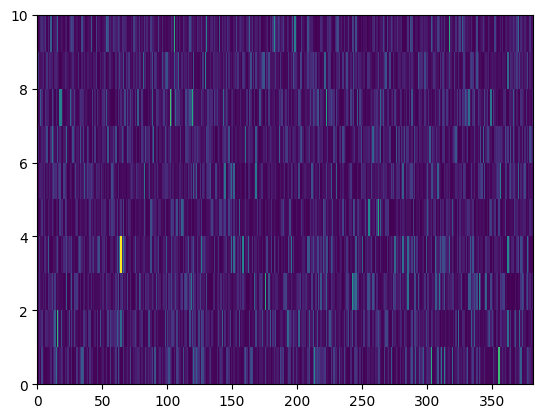

In [40]:
plt.pcolormesh(np.abs(x_train_s[0,:,:,0]**2 + x_train_s[0,:,:,1]**2))

In [41]:
# x_vals_s.shape, y_val_s.shape

In [42]:
def get_p_det_metric(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return np.interp(0.01, fpr, tpr)
    

In [43]:
def p_det(y_true, y_pred): 
    return tf.numpy_function(get_p_det_metric, (y_true, y_pred), tf.double)


# interpolate.interp1d(fpr, tpr)(0.01)

In [44]:
# Define the model.

# act = tf.keras.layers.LeakyReLU(alpha=0.01)
act = 'relu'

reg = tf.keras.regularizers.L2(
    l2=0.000000001)

input = tf.keras.Input(shape=(x_train_s.shape[1], x_train_s.shape[2], x_train_s.shape[3],))
x_layer = tf.keras.layers.Conv1D(64, (100), strides=16, kernel_regularizer=reg, activation=act, kernel_initializer='he_normal')(input)
x_layer = tf.keras.layers.Conv2D(64, (2, 16), kernel_regularizer=reg, strides=(1, 4), activation=act, kernel_initializer='he_normal')(x_layer)
x_layer = tf.keras.layers.Flatten()(x_layer)
# x = tf.keras.layers.Dense(16, activation=act)(x)
x_layer = tf.keras.layers.Dense(32, activation=act, kernel_regularizer=reg)(x_layer)
x_layer = tf.keras.layers.Dense(16, activation=act, kernel_regularizer=reg)(x_layer)
x_layer = tf.keras.layers.Dense(8, activation=act, kernel_regularizer=reg)(x_layer)
x_layer = tf.keras.layers.Dense(4, activation=act, kernel_regularizer=reg)(x_layer)
x_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x_layer)

In [45]:
tf_model = tf.keras.Model(inputs=input, outputs=x_layer)

In [46]:
tf_model.compile(
                optimizer='adam',
                 loss='binary_crossentropy',
              metrics=['accuracy', p_det],
                )

In [47]:
tf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 382, 4)]      0         
                                                                 
 conv1d (Conv1D)             (None, 10, 18, 64)        25664     
                                                                 
 conv2d (Conv2D)             (None, 9, 1, 64)          131136    
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 32)                18464     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136   

In [48]:
# checkpoint_filepath = f
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/transform/depth_10/weights/weights.epoch_{epoch:02d}-val_p_det_{val_p_det:.2f}.hdf5",
    save_weights_only=True,
    monitor='val_p_det',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=False)


# /content/drive/MyDrive/transform/depth_10/"./weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [49]:
EPOCHS = 5000

# history = tf_model.fit(x_train_s, y_train_s, epochs=EPOCHS)

# , validation_data=(x_val_s, y_val_s)
history = tf_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[model_checkpoint_callback])

# 

Epoch 1/5000
149/149 [==============================] - 24s 159ms/step - loss: 1.4200 - accuracy: 0.5414 - p_det: 0.2232 - val_loss: 0.6922 - val_accuracy: 0.5340 - val_p_det: 0.0110
Epoch 3/5000
149/149 [==============================] - 35s 237ms/step - loss: 0.6032 - accuracy: 0.6991 - p_det: 0.4823 - val_loss: 0.6886 - val_accuracy: 0.5520 - val_p_det: 0.0457
Epoch 4/5000
149/149 [==============================] - 24s 159ms/step - loss: 0.6014 - accuracy: 0.7364 - p_det: 0.5336 - val_loss: 0.6898 - val_accuracy: 0.5380 - val_p_det: 0.0111
Epoch 5/5000
 95/149 [==================>...........] - ETA: 8s - loss: 0.5348 - accuracy: 0.7623 - p_det: 0.8619

KeyboardInterrupt: ignored

NameError: ignored

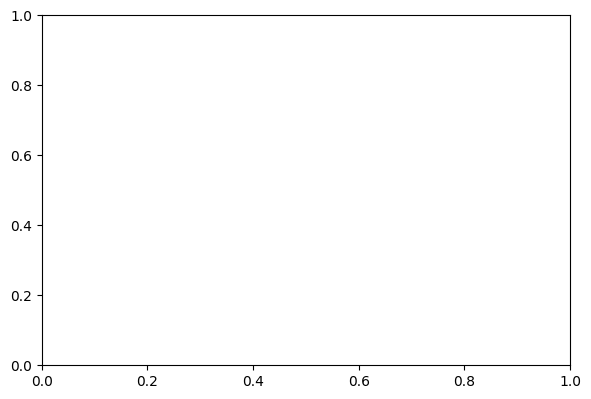

In [ ]:

plt.figure(figsize=(15, 10))

plt.subplot(221)

plt.plot(np.arange(0, EPOCHS), history.history['loss'], label="Training Loss", marker="x", ms=3)
plt.plot(np.arange(0, EPOCHS), history.history['val_loss'], label="Validation Loss", marker="x", ms=3)

plt.legend()

plt.subplot(222)

metric = 'p_det'

plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

plt.ylim(0, 1)

plt.legend()

plt.subplot(223)

metric = 'accuracy'

plt.plot(np.arange(0, EPOCHS), history.history[metric], label="Training pdet", marker="x", ms=3)
plt.plot(np.arange(0, EPOCHS), history.history['val_' + metric], label="Validation pdet", marker="x", ms=3)

plt.ylim(0, 1)

plt.legend()

In [ ]:
result = tf_model.evaluate(test_dataset)

4/4 [==============================] - 0s 47ms/step - loss: 0.0195 - accuracy: 0.9980 - p_det: 1.0000


In [ ]:
test_predicted_ys = tf_model.predict(x_test_s)

16/16 [==============================] - 1s 19ms/step


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_s, test_predicted_ys)

Text(0, 0.5, 'True Positive Rate')

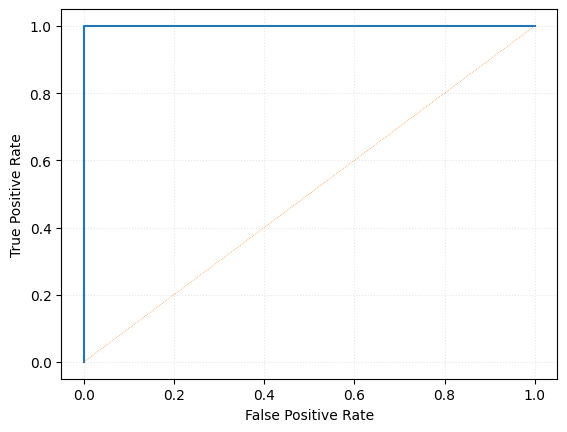

In [ ]:
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], ls="dotted", lw=0.5)

plt.grid(alpha=0.3, ls="dotted")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

In [ ]:
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], ls="dotted", lw=0.5)

plt.grid(alpha=0.3, ls="dotted")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.xlim(0, 0.1)

In [ ]:
# fpr, tpr, thresholds = metrics.roc_curve(label, probability)
interpolate.interp1d(fpr, tpr)(0.01)

In [ ]:
tpr_intrp(0.08)